In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import gc
import PIL.Image as Image
from sklearn.model_selection import train_test_split
import torch.nn as nn
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
import numpy as np

def plot_roc_auc(y_pred, label):
    auc = roc_auc_score(label, y_pred)
    plt.plot(*roc_curve(label, y_pred)[:2], label=f'AUC={auc:.4f}')
    plt.plot([0, 1], [0, 1], '--', color='black')
    plt.legend(fontsize='large')
    plt.grid()

def plot_confusion_matrix(y_pred, label):
    conf_matrix = confusion_matrix(y_pred, label)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(conf_matrix)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_precision_recall_curve(y_proba, label):
    precision, recall, thresholds = precision_recall_curve(label, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

def cosine_distance(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return (dot_product / (norm_vec1 * norm_vec2))

def plot_weight(model):
    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights += param.data.cpu().numpy().flatten().tolist()
    weights = np.array(weights)

    # Построение гистограммы
    plt.hist(weights, bins=80, range = (-0.03, 0.03))
    plt.xlabel('Weight values')
    plt.ylabel('Frequency')
    plt.show()

def calculate_correct(y_true, y_pred):
    correct = (y_true == y_pred).squeeze()
    return correct.sum()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
basic_model = models.swin_v2_t(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/swin_v2_t-b137f0e2.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_t-b137f0e2.pth
100%|██████████| 109M/109M [00:07<00:00, 16.1MB/s] 


In [29]:
class FeatureExtractor:
    def __init__(self, model, device='cuda:0'):
        self._model = model
        self._avgpool_features = None
        self._device = device
        self._model.avgpool.register_forward_hook(self._get_features)

    def get_dataset_features(self, loader):
        self._model.eval().to(self._device)
        features = []
        labels = []
        for sample, label in tqdm(loader, total=len(loader)):
            sample = sample.unsqueeze(0).to(self._device)
            _ = self._model(sample.to(self._device))
            features.append(self._avgpool_features)
            labels.append(label)
        return np.array(features), np.array(labels)

    def _get_features(self, module, inputs, output):
        self._avgpool_features = np.squeeze(output.data.cpu().numpy(), axis=(2, 3))

In [5]:
transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),     
            transforms.RandomVerticalFlip(p=0.5), 
            transforms.RandomEqualize(p=0.2),
            transforms.RandomApply(transforms=[transforms.Grayscale(num_output_channels=3)], p=0.1),
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, csv_file, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.valid_data = []
        self.data = pd.read_csv(csv_file)
        for idx in range(self.data.shape[0]):
            img_name = self.data['id'][idx]
            img_path = os.path.join(self.root_dir, img_name)
            img_path = img_path if os.path.exists(img_path) else img_path + '.png'
            label = self.data['target'][idx]
            self.valid_data.append((img_path, label))
                
    def __len__(self):
        return len(self.valid_data)
    
    def __getitem__(self, index):
        image, label = self.valid_data[index]
        image = Image.open(image).convert('RGB')
        img = self.transform(image)
        return img, label

root_dir='/kaggle/input/ai-or-not5/images'
csv_train_file='/kaggle/input/ai-or-not5/DATASET3.csv'
csv_test_file='/kaggle/input/ai-or-not5/test.csv'
dataset = Custom_Dataset(root_dir, csv_train_file, transform)

In [6]:
class Custom_Model(nn.Module):
    def __init__(self, model, dropout_rate, latent_dim, device):
        super(Custom_Model, self).__init__()
        self.net = model
        self.net.head = nn.Sequential(
            nn.Linear(768, latent_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(latent_dim, 1)
        )
        self.net = self.net.to(device)

    def head_parameters(self):
        return self.net.head.parameters()

    def forward(self, x):
        return self.net(x)
    
model = Custom_Model(basic_model, dropout_rate=0.2, latent_dim=256, device=device)

In [8]:
batch_size = 8
num_workers = 8
test_size=0.2

train_dataset, val_dataset = train_test_split(dataset, test_size=test_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False, drop_last=True, num_workers=num_workers)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
class Trainer:    
    def __init__(self, model, criterion, config):
        self._model = model
        self._device = device
        self._criterion = criterion
        self._epochs = config['epochs']

        if config['only_top']:
            self._optimizer = torch.optim.AdamW(self._model.fresh_parameters(), lr=config['lr'], weight_decay=config['weight_decay'], amsgrad=True)
        else:
            self._optimizer = torch.optim.AdamW(self._model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'], amsgrad=True)        

    def fit(self, train_loader, val_loader):
        for epoch in range(self._epochs):
            self._model.train()
            train_loss, train_accuracy = self._run_epoch(epoch, train_loader, is_training=True)
            print('Train. loss: {}, accuracy: {}'.format(train_loss, train_accuracy))
            
            self._model.eval()
            val_loss, val_accuracy = self._run_epoch(epoch, val_loader, is_training=False)
            print('Validation. loss: {}, accuracy: {}'.format(val_loss, val_accuracy))
            torch.cuda.empty_cache()
            gc.collect()

    def _run_epoch(self, epoch, loader, is_training):
        loss = 0
        correct = 0
        if is_training:
            pbar = tqdm(enumerate(loader), total=len(loader), desc='Epoch {}'.format(epoch), ncols=0)
        else:
            pbar = tqdm(enumerate(loader), total=len(loader), desc='Val', ncols=0)
        
        for i, data in pbar:
            batch_loss, batch_correct = self._step(data, is_training)
            loss += batch_loss
            correct += batch_correct
        
        pbar.close()
        loss /= len(loader)
        accuracy = correct / len(loader.dataset)
        return loss, accuracy
    
    def _step(self, data, is_training=True):
        images = data[0].to(self._device)
        y_true = data[1].to(self._device)

        if is_training:
            self._optimizer.zero_grad()

        with torch.set_grad_enabled(is_training):
            y_pred = self._model(images)
            y_pred = y_pred.squeeze()
            loss = self._criterion(y_pred, y_true.float())

            if is_training:
                loss.backward()
                self._optimizer.step()
            
        probas = torch.sigmoid(y_pred)
        labels = (probas > 0.5).int()
        correct = calculate_correct(y_true=y_true, y_pred=labels)

        return loss.item(), correct.item()

class Evaluator:    
    def __init__(self, model, device='cuda:0'):
        self._model = model
        self._device = device

    def predict(self, loader):
        y_pred = []
        self._model.eval().to(self._device)
        labels = []
        with tqdm(enumerate(loader), total=len(loader)) as pbar:
            for i, data in pbar:
                batch_pred, batch_label = self._step(data)
                y_pred.append(batch_pred)
                labels.append(batch_label)
        return np.concatenate(y_pred), np.concatenate(labels)
    
    def _step(self, data):
        images = data[0].to(self._device)
        labels = data[1]
        with torch.no_grad():
            y_pred = self._model(images)
        
        y_pred = y_pred.squeeze()
        y_pred = torch.sigmoid(y_pred)

        return y_pred.cpu().data.numpy(), labels

In [12]:
torch.cuda.empty_cache()
gc.collect()

config = {
    'lr': 1e-5,
    'epochs': 6,
    'only_top': False,
    'weight_decay':1e-3
}
loss_f = nn.BCEWithLogitsLoss()
trainer = Trainer(model, loss_f, config)
trainer.fit(train_loader, val_loader)

In [25]:
evaluator = Evaluator(model, device='cuda')
y_pred, label_val = evaluator.predict(val_loader)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/37 [00:00<?, ?it/s]


TypeError: FeatureExtractor._get_features() takes 2 positional arguments but 4 were given

Log Loss: 0.0013254624624057007


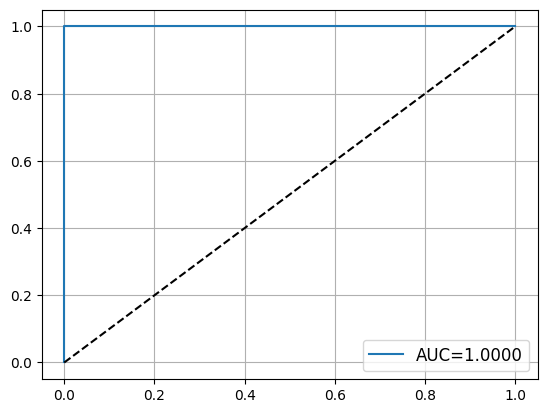

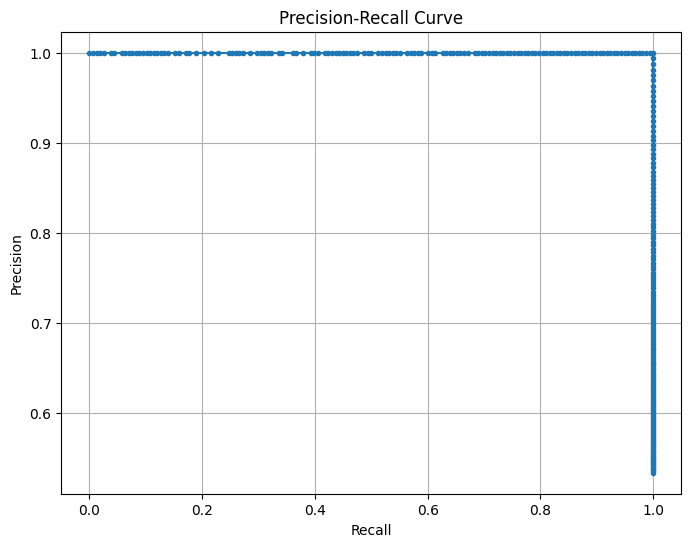

In [22]:
plot_roc_auc(y_pred, label_val)
logloss = log_loss(label_val, y_pred) # в качестве целевой метрики выбран logloss
print("Log Loss:", logloss)
plot_precision_recall_curve(y_pred, label_val)

In [30]:
extractor = FeatureExtractor(model.net, device=device)
X, y = extractor.get_dataset_features(dataset)
X = X.reshape(X.shape[0], X.shape[2])

  0%|          | 0/1479 [00:00<?, ?it/s]


TypeError: FeatureExtractor._get_features() takes 2 positional arguments but 4 were given

In [ ]:
import matplotlib.pyplot as plt

# Создаем объект PCA
pca = PCA()

# Обучаем PCA на данных X
pca.fit(X)

# Получаем объясненную дисперсию каждой компоненты
explained_variance = pca.explained_variance_ratio_

# Создаем график компонент
plt.figure(figsize=(8, 6))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center')
plt.xlabel('Компоненты')
plt.ylabel('Объясненная дисперсия')
plt.title('График компонент')
plt.show()
